# Prediction model of RRFs of compounds detected by GC/MS

## 0. Conception

*Which decision are we going to inform?* \
We will assist labs by predicting RRFs detected by GC/MS

*What is our prediction estimand?* \
Input data :  Several molecular and physico-chemical characteristics.
The outcome is continuous : Relative Response Factor

*How can you measure the model's success?* \
The model's success will be mostly assessed with the one having the highest R², lowest test MSE. \

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chemistry
import pubchempy as pcp
from rdkit import Chem

# Scikit-learn
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data acquisition

The excel file was created by manually copying the table from the US FDA CLAP list and the table S1 supplementary data from Yun et al.


In [2]:
df = pd.read_excel('processed_data/RRFML.xlsx')

## 2. Exploratory data analysis

In [3]:
df.describe()


,DBE,MW,BP,logP,Refractive Index,5 µg/mL,10 µg/mL,20 µg/mL
count,92.000000,92.000000,91.000000,92.000000,89.000000,92.000000,92.000000,92.000000
mean,5.309783,303.179348,359.889011,6.055326,1.523247,0.374228,0.406674,0.412489
std,4.100953,160.177748,127.047844,4.117937,0.087404,0.463968,0.484548,0.446450
min,0.000000,102.200000,148.300000,-0.660000,1.289000,0.000000,0.000000,0.000000
25%,2.000000,195.550000,259.400000,3.142500,1.454000,0.030250,0.037250,0.053500
50%,4.000000,285.450000,359.400000,5.355000,1.499000,0.207000,0.287000,0.278000
75%,8.000000,375.600000,435.500000,8.475000,1.585000,0.534000,0.527000,0.608500
max,20.000000,1177.600000,779.000000,23.000000,1.757000,2.551000,2.143000,1.810000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Code               92 non-null     object 
 1   IUPAC name         92 non-null     object 
 2   CAS #              92 non-null     object 
 3   Empirical Formula  92 non-null     object 
 4   DBE                92 non-null     float64
 5   MW                 92 non-null     float64
 6   BP                 91 non-null     float64
 7   pKa                65 non-null     object 
 8   logP               92 non-null     float64
 9   Refractive Index   89 non-null     float64
 10  5 µg/mL            92 non-null     float64
 11  10 µg/mL           92 non-null     float64
 12  20 µg/mL           92 non-null     float64
dtypes: float64(8), object(5)
memory usage: 9.5+ KB


## 3. Data preprocessing

We will first convert the CAS number of the extractables into Smiles using pubchem library. This is necessary to run the pretrained model 

In [5]:
def get_smiles_from_cas(cas):
    """Utility to fetch SMILES via PubChem"""
    try:
        results = pcp.get_compounds(cas, 'name')
        if results:
            return results[0].smiles
    except Exception as e:
        return None
    return None

df['SMILES'] = df['CAS #'].apply(get_smiles_from_cas)


This CAS number '68515-75-3' was manually added since the automation did not work.

In [6]:
target_cas = '68515-75-3'
manual_smiles = 'CCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'

df.loc[df['CAS #'] == target_cas, 'SMILES'] = manual_smiles
df_clean = df.dropna(subset=['SMILES', '5 µg/mL']).reset_index(drop=True)

## Model Setup

Model used ChemBERTa:  https://github.com/deepforestsci/chemberta3 
https://github.com/deepchem/deepchem/tree/master

But MoLFormer could also be used because it already includes the PubChem database. to investigate.

In [7]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
#model_name = "DeepChem/ChemBERTa-100M-MLM"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(smiles_list):
    return tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Define Dataset Class
class RRFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Define Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.flatten()
    return {
        'rmse': np.sqrt(mean_squared_error(labels, predictions)),
        'mae': mean_absolute_error(labels, predictions),
        'r2': r2_score(labels, predictions)
    }

# K-fold Cross Validation Loop

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results for final plotting
all_preds = []
all_labels = []
all_r2_scores = []

X = np.array(df_clean['SMILES'].tolist())
y = np.array(df_clean['5 µg/mL'].tolist())
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\n{'='*20} Processing Fold {fold}/5 {'='*20}")
    
    # A. Split Data
    train_smiles, val_smiles = X[train_index], X[val_index]
    train_labels, val_labels = y[train_index], y[val_index]

    # B. Tokenize
    train_encodings = tokenize_data(train_smiles.tolist())
    val_encodings = tokenize_data(val_smiles.tolist())

    # C. Create Datasets
    train_dataset = RRFDataset(train_encodings, train_labels)
    val_dataset = RRFDataset(val_encodings, val_labels)

    # D. Initialize New Model (Fresh weights for every fold)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',
        num_train_epochs=40,
        per_device_train_batch_size=8,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="r2",
        logging_steps=10,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # E. Train
    trainer.train()

    # F. Evaluate
    predictions = trainer.predict(val_dataset)
    preds_flat = predictions.predictions.flatten()
    
    # Store for plotting
    all_preds.extend(preds_flat)
    all_labels.extend(val_labels)
    
    r2 = predictions.metrics['test_r2']
    all_r2_scores.append(r2)
    print(f"Fold {fold} R2: {r2:.4f}")
    
    fold += 1

# Summary Stats
print(f"\nMean R2: {np.mean(all_r2_scores):.4f} (+/- {np.std(all_r2_scores):.4f})")


==================== Processing Fold 1/5 ====================


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.324700,0.366442,0.605345,0.376622,-0.419585
2,0.278100,0.328030,0.572739,0.366997,-0.270778
3,0.249200,0.296888,0.544875,0.359468,-0.150137
4,0.261300,0.276150,0.525500,0.353999,-0.069796
5,0.236600,0.259355,0.509269,0.351703,-0.004734
6,0.205600,0.244220,0.494186,0.352826,0.053901
7,0.204800,0.235556,0.485341,0.354328,0.087463
8,0.211500,0.230033,0.479618,0.354357,0.108859
9,0.188500,0.224624,0.473945,0.356826,0.129815
10,0.175400,0.219562,0.468574,0.357822,0.149424


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\s

Fold 1 R2: 0.3282

==================== Processing Fold 2/5 ====================


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.387700,0.181207,0.425684,0.247669,-0.427549
2,0.840500,0.162316,0.402884,0.231477,-0.278726
3,0.291500,0.148734,0.385660,0.224624,-0.171727
4,0.277900,0.140506,0.374841,0.242871,-0.106906
5,0.456400,0.138007,0.371493,0.262062,-0.087220
6,0.224800,0.141245,0.375826,0.282192,-0.112731
7,0.218900,0.146271,0.382454,0.296986,-0.152327
8,0.214200,0.151052,0.388654,0.306528,-0.189987
9,0.188700,0.153956,0.392372,0.311619,-0.212868
10,0.183900,0.153455,0.391733,0.312043,-0.208922


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\s

Fold 2 R2: -0.0872

==================== Processing Fold 3/5 ====================


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.260700,0.453565,0.673473,0.475593,-0.944926
2,0.240600,0.408491,0.639133,0.448504,-0.751645
3,0.234100,0.371554,0.609552,0.433100,-0.593254
4,0.200300,0.339973,0.583072,0.423164,-0.457833
5,0.195000,0.317724,0.563671,0.414539,-0.362429
6,0.176700,0.301824,0.549385,0.406056,-0.294248
7,0.171300,0.287882,0.536546,0.397531,-0.234463
8,0.172200,0.281698,0.530752,0.392604,-0.207945
9,0.168100,0.277318,0.526610,0.388460,-0.189163
10,0.331600,0.272882,0.522381,0.384403,-0.170142


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\s

Fold 3 R2: 0.1453

==================== Processing Fold 4/5 ====================


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.379600,0.143334,0.378595,0.281206,-1.116846
2,0.339700,0.121153,0.348070,0.256067,-0.789252
3,0.304700,0.103088,0.321074,0.238179,-0.522470
4,0.282000,0.090278,0.300463,0.235438,-0.333277
5,0.271400,0.081728,0.285881,0.232869,-0.207007
6,0.253200,0.075235,0.274291,0.230533,-0.111121
7,0.226100,0.070558,0.265627,0.231634,-0.042040
8,0.225600,0.067705,0.260202,0.229705,0.000094
9,0.232400,0.065947,0.256801,0.227289,0.026057
10,0.229400,0.064182,0.253341,0.225422,0.052126


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\s

Fold 4 R2: 0.3168

==================== Processing Fold 5/5 ====================


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.305900,0.441719,0.664619,0.345500,-0.327444
2,0.391300,0.409330,0.639789,0.322758,-0.230110
3,0.244600,0.381627,0.617760,0.302651,-0.146857
4,0.221000,0.359370,0.599475,0.289270,-0.079970
5,0.207900,0.342733,0.585434,0.287831,-0.029974
6,0.208000,0.330630,0.575004,0.290670,0.006399
7,0.208500,0.320050,0.565729,0.299174,0.038193
8,0.198400,0.311248,0.557896,0.309655,0.064643
9,0.164800,0.304768,0.552058,0.316729,0.084116
10,0.176800,0.300306,0.548002,0.319052,0.097526


c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\misak\anaconda3\envs\APPY2025\Lib\s

Fold 5 R2: 0.2823

Mean R2: 0.1971 (+/- 0.1564)


# Visualisation

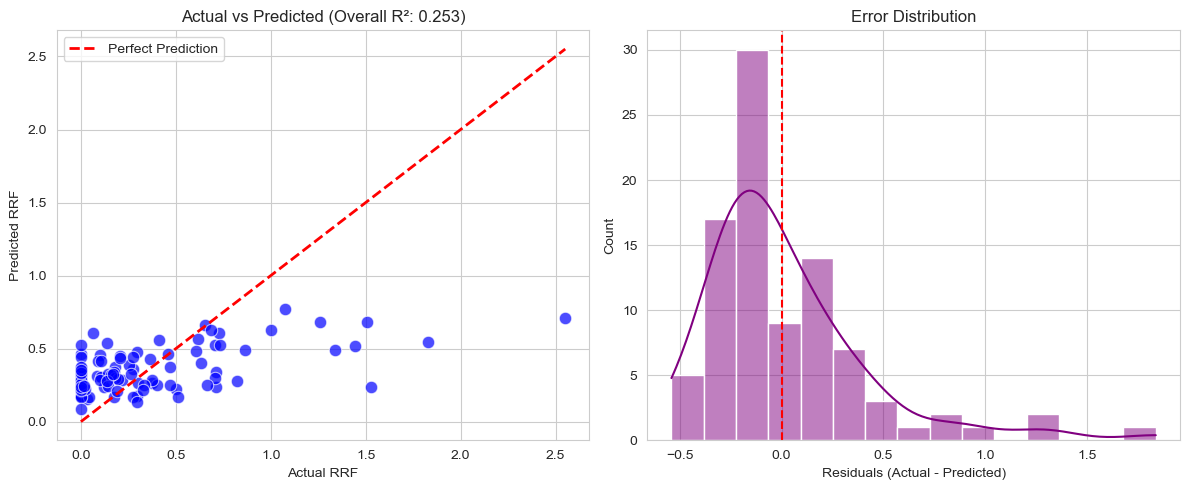

In [9]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_labels, y=all_preds, alpha=0.7, color='blue', s=80)
# Add Identity Line (Perfect Prediction)
max_val = max(max(all_labels), max(all_preds))
min_val = min(min(all_labels), min(all_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual RRF')
plt.ylabel('Predicted RRF')
plt.title(f'Actual vs Predicted (Overall R²: {r2_score(all_labels, all_preds):.3f})')
plt.legend()

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = all_labels - all_preds
sns.histplot(residuals, kde=True, bins=15, color='purple')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

In [10]:
import shap
import torch
import transformers
import numpy as np

# 1. Load your trained model and tokenizer
# Replace './results/checkpoint-500' with the actual path to your best model folder
model_path = "./results_fold_5/checkpoint-400" 
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-100M-MLM")

# 2. Define a Prediction Pipeline
# SHAP needs a simple function: Input Text -> Output Number
def predict_function(smiles_list):
    # Tokenize
    inputs = tokenizer(
        list(smiles_list), 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    )
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Predict
    with torch.no_grad():
        logits = model(**inputs).logits
    
    return logits.cpu().detach().numpy().flatten()

# 3. Initialize the SHAP Explainer
# We use the "Partition" explainer which is best for Transformer text models
explainer = shap.Explainer(predict_function, tokenizer)

# 4. Select a "Low Responder" to analyze
# Let's find a compound where the actual RRF was very low (e.g., < 0.2)
low_responder_smiles = df_clean[df_clean['5 µg/mL'] < 1]['SMILES'].iloc[0]

print(f"Analyzing Low Responder: {low_responder_smiles}")

# 5. Calculate SHAP values
shap_values = explainer([low_responder_smiles])

# 6. Visualize
shap.plots.text(shap_values)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Analyzing Low Responder: CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CCC(=O)OCC(COC(=O)CCC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C)(COC(=O)CCC3=CC(=C(C(=C3)C(C)(C)C)O)C(C)(C)C)COC(=O)CCC4=CC(=C(C(=C4)C(C)(C)C)O)C(C)(C)C
